In [63]:
import wikipedia
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer #For BOW word representation
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec

In [2]:
#Using Wikipedia to get the content
pages = ['Facebook','Google','Amazon (company)','Apple','Microsoft','WalmartLabs','Samsung','Twitter',
         'Motorolla','Intel','Cisco','Alibaba','OnePlus','Sony']

content = {}
content_list = []
for each in pages:
    print(each)
    content_list.append(wikipedia.page(each).content)
    content[each] = wikipedia.page(each).content

In [3]:
#Combining all the documents together
collated_content = " ".join(content_list)

#Total number of words
print(len(collated_content))

doc_tokens = nltk.word_tokenize(collated_content)

#Getting the stop words
stop_words = set(stopwords.words('english'))

all_stops = stop_words | set(string.punctuation) | set([each.lower() for each in pages])

#Removing stop words
doc_tokens = [each for each in doc_tokens if each.lower() not in all_stops]

668224


In [4]:
#Getting the word frequency using token_freq
token_freq = Counter(doc_tokens)
token_freq.most_common(20)

[("'s", 807),
 ('``', 712),
 ("''", 666),
 ('===', 614),
 ('company', 541),
 ('==', 288),
 ('announced', 276),
 ('users', 260),
 ('also', 260),
 ('million', 259),
 ('====', 248),
 ('Alabama', 247),
 ('first', 201),
 ('billion', 200),
 ('new', 191),
 ('state', 187),
 ('Amazon', 184),
 ('2011', 178),
 ('Motorola', 170),
 ('would', 161)]

In [5]:
#https://stackoverflow.com/questions/19198920/using-counter-in-python-to-build-histogram

labels, values = zip(*token_freq.most_common(20))

indexes = np.arange(len(labels))
width = 1

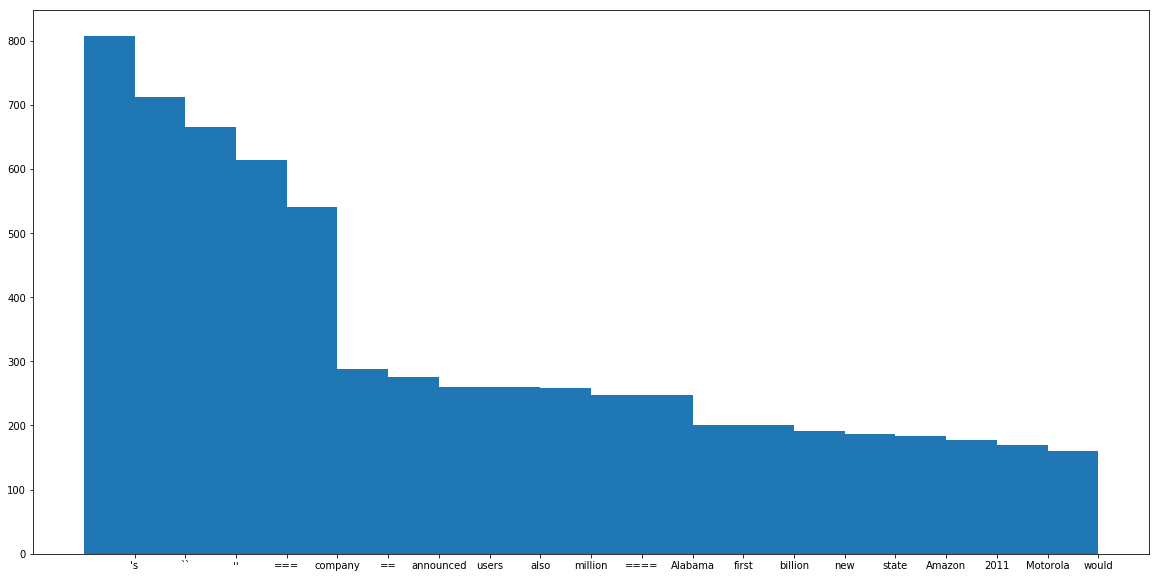

In [6]:
#Setting up the plot
plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

We see some companie's name like 'Amazon', 'Motorola' since they were not removed from the corpus. While the other poular words are 'million','users','billion','first', and so on. We need to check if they are appearing because of single document are they are appearing across

#### Word cloud

(-0.5, 799.5, 399.5, -0.5)

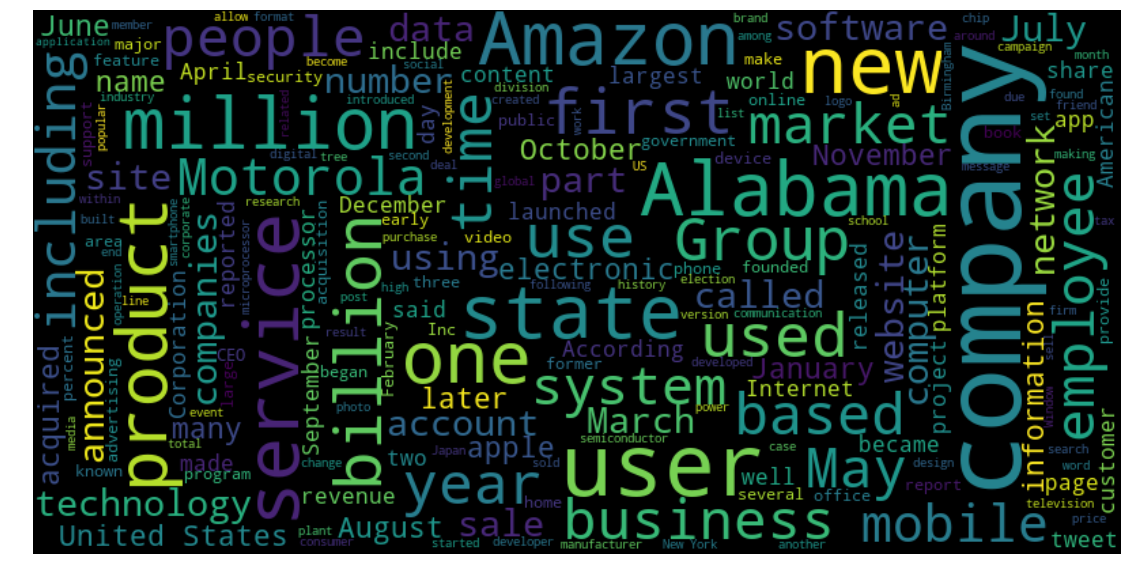

In [7]:
word_cloud_text = " ".join(doc_tokens)

wordcloud = WordCloud(width = 800, height=400,max_font_size=80).generate(word_cloud_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#### It is obvious that we will see many tech realted words like 'computer', 'service','mobile','technology','company','site'.
#We also see many month words which has to be removed. We might have to remove them for document similarity purposes

#### BOW word representation

In [8]:
bow_vec = CountVectorizer(ngram_range = (1,3),min_df = 5)

In [9]:
bow_vec.fit_transform(doc_tokens).todense().shape

(66823, 2745)

In [10]:
list(bow_vec.vocabulary_.items())[1:15]

[('online', 1769),
 ('social', 2319),
 ('media', 1597),
 ('networking', 1709),
 ('service', 2257),
 ('company', 628),
 ('based', 382),
 ('menlo', 1609),
 ('park', 1822),
 ('california', 475),
 ('website', 2684),
 ('launched', 1457),
 ('february', 1038),
 ('2004', 71)]

#### TF-IDF word representation

In [11]:
tfidf_vec = TfidfVectorizer(ngram_range = (1,3),min_df = 5)

In [25]:
tfidf_vec.fit_transform(doc_tokens).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Tf-idf doesn't make sense here since we neithe have documents or sentences as spearate entities. Now instead of vectorizing by words we tokenize by sentence so that we can
* Find similar sentences
* Generate Language model

### Sentence level tokenization

In [44]:
#Tokenizing into sentences
doc_sentence = sent_tokenize(collated_content)

In [46]:
#Total number of sentences it the document
len(doc_sentence)

3973

In [47]:
#Number of words per sentence
words_per_sen = [len(word_tokenize(each)) for each in doc_sentence]

#### Histogram of the sentence size

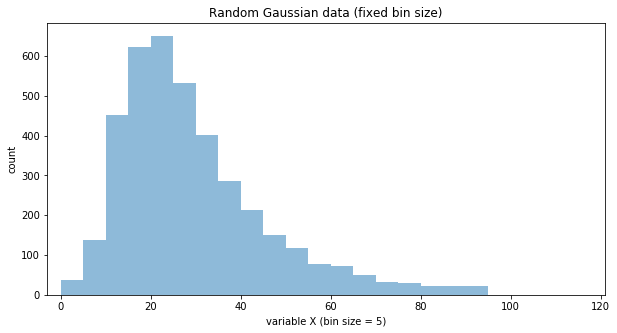

In [61]:
bins = np.arange(-100, 100, 5) # fixed bin size
plt.figure(figsize=(10,5))
plt.xlim([min(words_per_sen)-5, max(words_per_sen)-150])
plt.hist(words_per_sen, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')
plt.show()

Mostly the sentence size is around 20-30 words. But, it sometimes goes above 80 (rarely). We need to take care of it while creating the batch size while creating language models

## Word2Vec and Glove representation of words in sentences

In [66]:
sent_to_words = [word_tokenize(each) for each in doc_sentence]

In [67]:
model = Word2Vec(sent_to_words, min_count=1)

In [70]:
print(model)
words = list(model.wv.vocab)

Word2Vec(vocab=14908, size=100, alpha=0.025)


In [75]:
len(words)

14908

In [78]:
million_similar_words = [sum(model['million'] * model[each]) for each in words]

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [83]:
sum(model['million'] * model[','])

C:\Users\arvra\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


79.7380714969886

In [98]:
[words[each] for each in np.argsort(million_similar_words)[-5:-1]]

['by', '(', 'to', 'and']

#### Immediate steps
* Understand what word2vec function does
* Remove the stop words from the sentences
* Try to get the pre-calculated word2vec values

In [15]:
### STEPS YOU WISH TO DO
#1) Tokenize each work - word ferquency - word cloud
#2) Get word2vec and glove representation of each word - select a word and see the most similar word to it
#3) Now, try to do the preprocessing and see if that changes

## LANGUAGE MODEL ### 
#4) Setence level tokenization
#5) Create a language model with LSTM/GRU
#6) Now try to generate language on your own

## TOPIC MODELING ### 
#7) Select around 2-3 topics and see if there is any proper topics


## INCREASE THE SIZE OF INPUT DATA AND SEE IF THE RESULT CHANGES ###
#8) REPEAT THE ABOVE STEPS

## Document similarity ##

### FINAL OUTPUT ###
#1) Generate language from where you start
#2) Suggest related topics for Wikipedia articles